# Continous Control

The chosen algorithm for this scenario is A2C. There are some benefits from adopting A2C. These reasons were:
 - It's good for limited resources as it utilizes same network for both actor and critic.
 - The reason above also may be one of the reasons that it converges faster than other algorithms.
 - Can be converted to asynchronous version fairly quickly.
 - Why not?
 
A2C Model:
 - As mentioned before, actor and critic heads share the same backbone. In the code, this network will be referred as "TwoHeadModel". 
 - Backbone has an (n_inputs x 128) layer and (128x128) layer afterwards.
 - Actor head is in (128xn_actions) size.
 - Critic head is in (128x1) size.

The agent takes advantage of A2C model mentioned above, and 20 averaged copies of itself for one trajectory. Has a length of 5 roll-out length, which basically means that each learning step utilizes 5 trajectories. Keeping trajectories between 4-6 seems logical. The reason is, too short trajectories may result a biased learning and too long trajectories may lead to high variance. 

The training code is as follows.

In [1]:
from collections import deque
import numpy as np
import torch
from tqdm.auto import trange, tqdm

from unityagents import UnityEnvironment

from agent import Agent

Here are some hyper-parameters employed during training. The choices are obvious from the naming. To explain the choices given below:
 - Learning rate: Learning rates often choose that value in reinforcement learning and makes a good starting point to just solving the environment.
 - Buffer size: This is also rollout size of the value function.
 - Gamma: This is the discount factor to utilize future rewards. It's better to be close to 1. However, I find this parameter to have most effect on the training process. Agent couldn't solve the environment with a gamma value of 0.99. However, could solve easily with 0.95. This may due to environments characteristic of state update. Early steps are valuable, but apperantly not for this environment. 
 
Notes on rolling out the past experiences: 
- Tried to employ Experience Replay method for rolling out. Was no success. It was obvious it will not work because A2C is an online learning algorithm.
- Using a sliding window of experience (for example using frame 1 to 5 than 2 to 6 than 3 to 7) did some work, but not as good as using unseen state values. (for example using frame 1 to 5 then 6 to 10 than 11 to 15).

In [2]:
args = {
    "lr": 1e-4,
    "buffer_size": 5,
    "batch_size": 5,
    "gamma": .95,
}
environment_path = "Reacher_Windows_x86_64/Reacher.exe"
termination_threshold=30
n_trajectories=int(2000)
max_t=1000

Let's easify the environment creation process. This may be useful for asynchronous agents.

In [3]:
def create_env(env_path):
    """
    Creates an rl environment
    :param env_path: Path to environment 
    :return: environment, state size, action size and brain name
    """
    env = UnityEnvironment(file_name=env_path)
    brain_name = env.brain_names[0]
    brain = env.brains[brain_name]

    env_info = env.reset()[brain_name]

    action_size = brain.vector_action_space_size

    states = env_info.vector_observations
    state_size = states.shape[1]

    return env, state_size, action_size, brain_name

Creation of A2C agent.

In [4]:
env, state_size, action_size, brain_name = create_env(env_path=environment_path)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
agent = Agent(state_size, action_size, args=args, device=device)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Training loop for training.

In [5]:
scores_deque = deque(maxlen=100)
scores = []
tqdm_bar = trange(1, n_trajectories, desc="Trajectories")
episode_bar = tqdm(total=max_t)
for i in tqdm_bar:
    state = env.reset(train_mode=True)[brain_name].vector_observations
    score = 0
    for t in range(1, max_t + 1):
        action, prob, q_value = agent.act(state)
        env_info = env.step(action.detach().cpu().data.numpy())[brain_name]
        next_state, reward, done = env_info.vector_observations, env_info.rewards, env_info.local_done
        agent.step(action, reward, prob, done, q_value)
        state = next_state
        score += np.mean(reward)
        if t % 100 == 0:
            episode_bar.set_description("Time Step T: {}, Score: {:.2f}".format(t, score))
            episode_bar.update(100)

    episode_bar.reset()
    tqdm_bar.set_description("Episode: {}, Score: {:.2f}".format(i, score))
    scores_deque.append(score)
    scores.append(score)
    
    if (i > 10) and (scores[-1] > scores[-2]):
        torch.save(agent.TwoHeadModel.state_dict(), 'checkpoint.pth')

    if np.mean(scores_deque) > termination_threshold:
        print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i - 100,
                                                                                     np.mean(scores_deque)))
        break

env.close()


Environment solved in 162 episodes!	Average Score: 30.02



Plot of scores overtime.

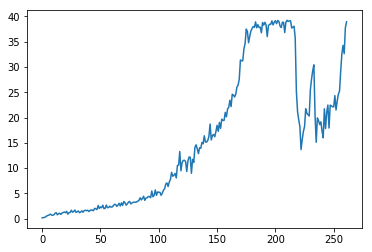

In [7]:
import matplotlib.pyplot as plt
plt.plot(scores)


## Conclusions

- A2C model seems to solve environment effectively.
- The reason why A2C model couldn't reach the maximum score is a gaussian noise being added at the output of the network. This process helps the model not to stuck in a local optima.
- Gamma parameter appears to be the most important parameter for A2C and should be adjusted accordingly to the environment.
- 

## Future Work
- Implementing other algorithms like D4GP, A3C etc.
- Implementing multi-threaded working environment for faster training
- Employment of pixel state should be fun but not a must. In real life, robotic arms usually does not have pixel states, but sensory data.

## Test the model!
One can simply test the trained model by running the code below.

In [ ]:
agent = Agent(state_size, action_size, args=args, device=device, eval_mode=True)
agent.TwoHeadModel.load_state_dict(torch.load("checkpoint.pth"))

while True:
    state = env.reset(train_mode=False)[brain_name].vector_observations
    score = 0
    for t in range(max_t):
        action, prob, q_value = agent.act(state)
        env_info = env.step(action.detach().cpu().data.numpy())[brain_name]
        next_state, reward, done = env_info.vector_observations, env_info.rewards, env_info.local_done
        state = next_state
        score += np.mean(reward)

    print("score: {}".format(score))



score: 39.19249912397939
score: 38.78649913305417
score: 37.794499155227236
score: 39.33099912088364
score: 39.22799912318588
score: 39.16499912459403
score: 39.30149912154302
score: 39.25849912250415


In [ ]:
# Shout out!
The postprocessing step was hard and was full of computation graph not being compiled and back propagation not happening. This A2C implementation help me out a lot! https://github.com/qiaochen/A2C/blob/master/agent.py